In [1]:
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns


In [2]:
data_path = os.path.join(os.getcwd(), '..', 'data', '04_feature', 'train_features.csv')
data = pd.read_csv(data_path)
data.shape

(307507, 12)

In [3]:
# Fonction pour déterminer le type de données approprié
def determine_int_type(max_value):
    if max_value <= np.iinfo(np.int8).max:
        return np.int8
    elif max_value <= np.iinfo(np.int16).max:
        return np.int16
    elif max_value <= np.iinfo(np.int32).max:
        return np.int32
    else:
        return np.int64

# Parcourir chaque colonne et convertir le type de données si nécessaire
for col in data.select_dtypes(include=[np.int64]).columns:
    max_value = data[col].max()
    new_type = determine_int_type(max_value)
    data[col] = data[col].astype(new_type)

float64_cols = data.select_dtypes(include=[np.float64]).columns
data[float64_cols] = data[float64_cols].astype(np.float32)

In [4]:
X = data.drop("TARGET", axis=1)
y = data["TARGET"]

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [6]:
def assess_model(y_pred_proba, y_test, threshold=0.5):
    y_pred = (y_pred_proba > threshold).astype(int)
    return {
        'auc-roc': roc_auc_score(y_test, y_pred_proba),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
    }
    

In [7]:
params = {
    'nthread': 4,
    'n_estimators': 10000,
    'learning_rate': 0.02,
    'num_leaves': 34,
    'colsample_bytree': 0.9497036,
    'subsample': 0.8715623,
    'max_depth': 8,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775,
    # 'random_state': 42,
}

# LightGBM classifier
model = LGBMClassifier(**params)

# Entraîner le modèle sur l'ensemble d'entraînement complet
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 19945, number of negative: 226060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081076 -> initscore=-2.427822
[LightGBM] [Info] Start training from score -2.427822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

In [12]:
# Prédire les probabilités sur l'ensemble de test
y_pred_proba = model.predict_proba(X_test)[:, 1]

metrics = assess_model(y_pred_proba, y_test)
print(f"Test AUC-ROC: {metrics['auc-roc']}")
print(f"Test F1: {metrics['f1']}")
print(f"Test Precision: {metrics['precision']}")
print(f"Test Recall: {metrics['recall']}")

Test AUC-ROC: 0.7426320925481666
Test F1: 0.06771325893701532
Test Precision: 0.4398034398034398
Test Recall: 0.03668032786885246


In [8]:
# Define a work cost function
def cost_metric(y_true, y_pred, cost_fn, cost_fp):
    _, fp, fn, _ = confusion_matrix(y_true, y_pred).ravel()
    cost = (fn * cost_fn) + (fp * cost_fp)
    normalized_cost = cost/len(y_pred)
    return normalized_cost

In [9]:
def custom_fbeta(y_true, y_pred, cost_fn, cost_fp, beta=2):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculer le F-score pondéré
    fbeta = fbeta_score(y_true, y_pred, beta=beta)

    # Pondérer les faux négatifs plus fortement
    weighted_fn = fn * cost_fn  # Coût des faux négatifs
    weighted_fp = fp * cost_fp   # Coût des faux positifs

    # Métrique personnalisée
    custom_score = fbeta - (weighted_fn + weighted_fp) / (tn + tp + fn + fp)

    return custom_score


In [10]:
def optimize_threshold(y_true, y_proba, cost_fn=10, cost_fp=1, thresholds=np.arange(0, 1.05, 0.05)):
    # Initialisation des variables pour stocker les résultats
    costs = []
    customfbetas = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        cost = cost_metric(y_true, y_pred, cost_fn, cost_fp)
        customfbeta = custom_fbeta(y_true, y_pred, threshold, cost_fn, cost_fp)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        costs.append(cost)
        customfbetas.append(customfbeta)
        precisions.append(precision)
        recalls.append(recall)

    def normalize(values):
        return (values - np.min(values)) / (np.max(values) - np.min(values))

    # Tracer le graphique du coût en fonction du seuil
    plt.plot(thresholds, normalize(precisions), marker='o', label='Precision')
    plt.plot(thresholds, normalize(recalls), marker='o', label='Recall')
    plt.plot(thresholds, normalize(costs), marker='o', label='Cost')
    plt.plot(thresholds, normalize(customfbetas), marker='o', label='Custom F Beta')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Normalized Precision, Recall, Costs, and Custom F-Beta\nCost FN={cost_fn} ; FP={cost_fp}')
    plt.legend()
    plt.show()

C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


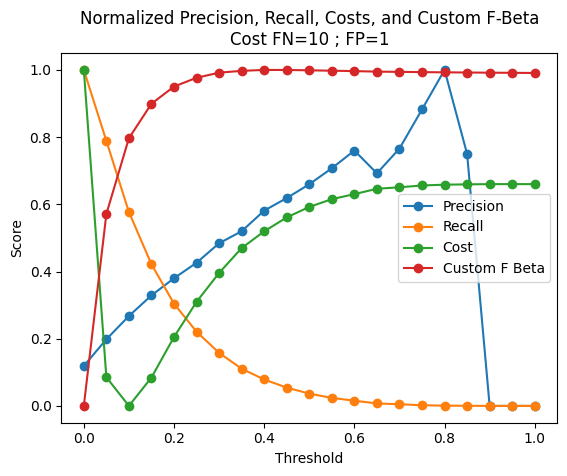

In [13]:
optimize_threshold(y_test, y_pred_proba)

C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


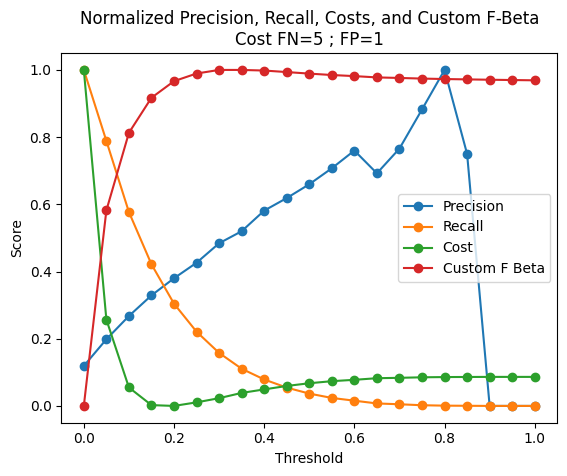

In [14]:
optimize_threshold(y_test, y_pred_proba, cost_fn=5, cost_fp=1)

C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


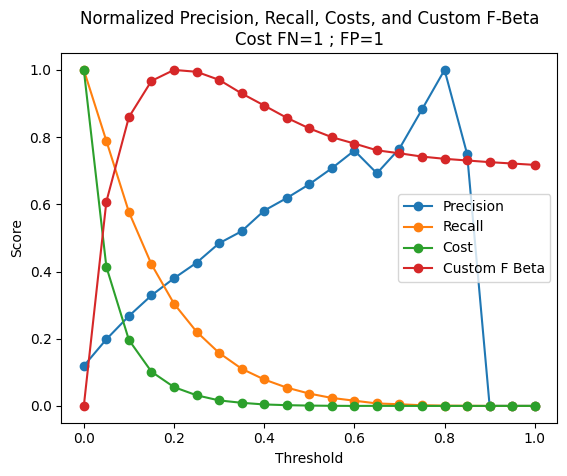

In [15]:
optimize_threshold(y_test, y_pred_proba, cost_fn=1, cost_fp=1)

Pour un coût comme demandé dans l'énoncé (FN=10, FP=1), le seuil idéal semble être aux alentours de 0.3 car il permet d'avoir un Custom F Beta qui est un rapport entre precision et rappel prenant en compte le déséquilibre des données TARGET

In [8]:
def log_model_metrics(model_name, features, params, metrics, threshold):
    with mlflow.start_run() as run:
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("num_features", len(features))
        mlflow.log_param("features", features)
        mlflow.log_param("params", params)
        mlflow.log_param("threshold", threshold)
        mlflow.log_metric("AUC-ROC", metrics['auc-roc'])
        mlflow.log_metric("F1", metrics['f1'])
        mlflow.log_metric("Precision", metrics['precision'])
        mlflow.log_metric("Recall", metrics['recall'])


In [9]:
from custom_threshold_model import CustomThresholdModel

custom_model = CustomThresholdModel(model, 0.3)

# Prédire les probabilités sur l'ensemble de test
y_pred, y_pred_proba, _ = custom_model.predict(X_test)

metrics = {
    'auc-roc': roc_auc_score(y_test, y_pred_proba),
    'f1': f1_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'custom-fbeta': custom_fbeta(y_test, y_pred, cost_fn=10, cost_fp=1),
}

print(f"Test AUC-ROC: {metrics['auc-roc']}")
print(f"Test F1: {metrics['f1']}")
print(f"Test Precision: {metrics['precision']}")
print(f"Test Recall: {metrics['recall']}")
print(f"Test Custom F Beta: {metrics['custom-fbeta']}")

log_model_metrics('LGBMClassifier', X_train.columns.tolist(), params, metrics, custom_model.threshold)

Test AUC-ROC: 0.7426320925481666
Test F1: 0.2119460500963391
Test Precision: 0.32271584241408213
Test Recall: 0.15778688524590165
Test Custom F Beta: -0.5187955829957251


In [10]:
from mlflow.tracking import MlflowClient

# Créer un client MLflow
client = MlflowClient()

model_path = os.path.join(os.getcwd(), "..", "data","06_models", "latest")

mlflow.sklearn.save_model(custom_model, model_path)

print(f"Meilleur modèle sauvegardé dans: {model_path}")

Meilleur modèle sauvegardé dans: c:\Users\Z478SG\Desktop\Ecole\OpenClassrooms-Projet-7\modeling\notebooks\..\data\06_models\latest
